In [1]:
import numpy as np
import emcee
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import corner
import time 
from scipy.stats import norm, laplace

from scipy.stats import anderson_ksamp, ks_2samp, shapiro
from scipy.optimize import curve_fit


In [2]:
file_path = "../../csvs/Res_3_feats/"
res_info = pd.read_csv(file_path + "Gaussian_Fits_317.csv")
res_info.tail()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
312,391.0,0.380109,4.832709,0.479577,0.021807,0.015415,1.130073e-07
313,393.0,0.181957,5.364817,1.022106,0.046608,0.033712,2.467449e-06
314,394.0,0.598461,6.614040,0.297937,0.013410,0.009552,1.640262e-08
315,395.0,0.409190,4.146248,0.439739,0.019946,0.013836,7.615377e-08
316,399.0,0.502488,6.190145,0.358946,0.016343,0.011388,3.460652e-08


In [3]:
#deltatimes.to_csv(file_path + "/deltatimes.csv", index=False)
res_delta_times = pd.read_csv(file_path + "/deltatimes.csv")
res_delta_times.tail()

,ID,t,t_shadow
312,391.0,2.815414e+04,5.142078e+04
313,393.0,7.103793e+05,3.221912e+05
314,394.0,2.527237e+06,3.198412e+06
315,395.0,8.670889e+03,7.556106e+03
316,399.0,2.319745e+06,3.153388e+06


In [4]:
# the above two are not the same size, since we removed the ones that didn't make the time cut
# trim by same criteria to see which are left
trimmed_res = res_delta_times[(res_delta_times["t"]<1e7) & (res_delta_times["t"]>1e4)
                    & (res_delta_times["t_shadow"]<1e7)& (res_delta_times["t_shadow"]>1e4)]
trimmed_res.head()

,ID,t,t_shadow
3,3.0,5.946887e+06,3.941298e+06
4,4.0,3.711381e+05,6.345772e+05
5,5.0,5.828498e+05,1.777121e+06
8,8.0,6.250862e+05,2.305529e+06
13,13.0,1.860666e+04,3.921713e+04


In [5]:
trimmed_res_info = res_info.loc[ res_info["ID"].isin(trimmed_res["ID"]) ]
trimmed_res_info.head()

3        3.0
4        4.0
5        5.0
8        8.0
13      13.0
       ...  
311    388.0
312    391.0
313    393.0
314    394.0
316    399.0
Name: ID, Length: 184, dtype: float64

In [7]:
# regenerate KS scores: from gaussian parameters
# do tests for only valid systems within the instability time range cuts
# sig level should be as low as possible, means it is rejected at anything higher
# An approximate significance level at which the null hypothesis for the provided samples can be rejected.

data_length = trimmed_res_info.shape[0]

sig_levels_and = np.zeros(data_length)
sig_levels_kstest = np.zeros(data_length)
ids = np.zeros(data_length)

for jj, planet_system_id in enumerate(trimmed_res_info["ID"].values):
    planet_sys = "Res_sys_{0}_500.csv".format(int(planet_system_id))
    if planet_system_id == 50:
        # nasty fix
        planet_sys = "Res_sys_{0}_1000.csv".format(int(planet_system_id))

    np.random.seed(jj)
    data =pd.read_csv(file_path +planet_sys, index_col = 0)
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)

    ids[jj] = planet_system_id
    index = np.where(planet_system_id==trimmed_res_info["ID"].values)[0][0]
    
    # normal we want to match
    test = np.random.normal(loc=trimmed_res_info.iloc[index]["Mean"], scale=trimmed_res_info.iloc[index]["Sigma"], size = data.shape[0])

    # anderson stats
    try:
        statistic, crit_val, sig_level =  anderson_ksamp([data, test])
    except:
        statistic, crit_val, sig_level = 0,0,0
        
    print(planet_system_id)
#     print("And",  statistic,  crit_val, sig_level)
    sig_levels_and[jj] = sig_level
    
    #ks test
    try:
        statistic, p_val = ks_2samp(data, test)
    except:
        statistic, p_val = 0,0
        
    sig_levels_kstest[jj] = p_val
    print("KS", statistic, p_val)

#     break

/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: p-value capped: true value larger than 0.25
/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: p-value floored: true value smaller than 0.001


3.0
KS 0.044 0.7189191850204419
4.0
KS 0.144 6.125192815723937e-05
5.0
KS 0.032 0.9603008958861495
8.0
KS 0.044 0.7189191850204419
13.0
KS 0.14 0.00010844915031869944
14.0
KS 0.04 0.8191511303355717
15.0
KS 0.07 0.1725563396262406
19.0
KS 0.046 0.6659218712646571
22.0
KS 0.064 0.25760726053364696
23.0
KS 0.114 0.00299005061044668
25.0
KS 0.074 0.12939616996710074
26.0
KS 0.048 0.6126241113875229
27.0
KS 0.034 0.9351121874342835
28.0
KS 0.054 0.4599232291065006
30.0
KS 0.072 0.14973189477810775
31.0
KS 0.032 0.9603008958861495
33.0
KS 0.07 0.1725563396262406
34.0
KS 0.18 1.714405022928302e-07
36.0
KS 0.128 0.0005458774578140435
37.0
KS 0.038 0.8636766933110154
38.0
KS 0.078 0.09546453231155308
41.0
KS 0.056 0.41348608403425674
42.0
KS 0.108 0.005832082533064598
43.0
KS 0.064 0.25760726053364696
46.0
KS 0.07 0.1725563396262406
47.0
KS 0.076 0.11136835555551457
48.0
KS 0.044 0.7189191850204419
49.0
KS 0.282 6.5179590696162995e-18
50.0
KS 0.064 0.033253124816560224
53.0
KS 0.102 0.01096896

In [8]:
scores = np.vstack([ ids, sig_levels_and, sig_levels_kstest])
print(scores.shape)
scores = pd.DataFrame(scores.T, columns=["ID", "Anderson_P", "KS_P"] )
scores.head()

(3, 184)


,ID,Anderson_P,KS_P
0,3.0,0.2500,0.718919
1,4.0,0.0010,0.000061
2,5.0,0.2500,0.960301
3,8.0,0.2500,0.718919
4,13.0,0.0041,0.000108


In [9]:
scores.to_csv(file_path + "/res_signficance_scores_new_scipy.csv",index=False)

In [10]:
sig_levels_kstest[sig_levels_kstest> 1.24e-5].size

168

In [11]:
res_sig_scores = pd.read_csv(file_path+ "/res_signficance_scores.csv")
# keep the top 93 percentile, significance value at 1.24e-5
print(res_sig_scores[(res_sig_scores["KS_P"] > 1.24e-5)].shape)
res_sig_scores.head()

(167, 4)


,ID,Anderson_P,KS_P,ShapiroW
0,100.0,0.000029,0.000040,7.678782e-24
1,101.0,0.032522,0.015203,3.526777e-08
2,108.0,0.427500,0.601915,5.864905e-06
3,109.0,0.540082,0.498083,3.596655e-06
4,113.0,0.026401,0.046678,7.397713e-13


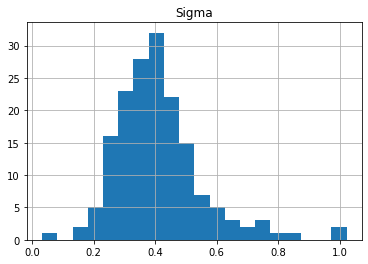

In [14]:
# additional cut based on KS_p value
res_sig_scores = pd.read_csv(file_path + "res_signficance_scores_new_scipy.csv")
res_sig_scores_keep = (res_sig_scores[(res_sig_scores["KS_P"] > 1.24e-5)])
trimmed_res_info_2 = trimmed_res_info[trimmed_res_info["ID"].isin((res_sig_scores_keep["ID"]).values)]
trimmed_res_info_2.hist("Sigma", bins = 20)
plt.show()

In [23]:
# repeat for randomly generated systems
random_delta_times = pd.read_csv("../../csvs/deltatimes.csv", index_col =0)
random_info_frame = pd.read_csv("../../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences_266.csv", index_col=0)
random_sig_scores = pd.read_csv("../../csvs/significance_scores.csv")
print(random_delta_times.shape)
print(random_info_frame.shape)
print(random_sig_scores.shape)
random_info_frame.head()

(25000, 3)
(266, 7)
(248, 4)


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08


In [24]:
# the above two are not the same size, since we removed the ones that didn't make the time cut
# trim by same criteria to see which are left
trimmed_random = random_delta_times[(random_delta_times["t"]<1e7) & (random_delta_times["t"]>1e4)
                    & (random_delta_times["t_shadow"]<1e7)& (random_delta_times["t_shadow"]>1e4)]
trimmed_random.shape
trimmed_random.head()

,runstring,t,t_shadow
1,0000001.bin,1.348749e+05,213307.156880
21,0000021.bin,3.590242e+05,646731.388681
22,0000022.bin,2.025537e+06,311291.666001
25,0000025.bin,3.708340e+05,671974.880182
28,0000028.bin,3.374641e+04,41949.192113


In [26]:
# some systems were created outside of the time range, so the time curs have to be applied 
trimmed_random_info = random_info_frame.loc[ random_info_frame["ID"].isin(trimmed_random.index) ]
trimmed_random_info.shape

(248, 7)

In [28]:
# Recompute the random sig scores as well

data_length = trimmed_random_info.shape[0]

sig_levels_and = np.zeros(data_length)
sig_levels_kstest = np.zeros(data_length)
ids = np.zeros(data_length)

for jj, planet_system_id in enumerate(trimmed_random_info["ID"].values):
    # Sys_24923_1e8.csv
    planet_sys = "Sys_{0}_1e8.csv".format(int(planet_system_id))
   
    np.random.seed(jj)
    data =pd.read_csv("../../../Long300/"+planet_sys, index_col = 0)

    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)

    ids[jj] = planet_system_id
    index = np.where(planet_system_id==trimmed_random_info["ID"].values)[0][0]
    
    # normal we want to match
    test = np.random.normal(loc=trimmed_random_info.iloc[index]["Mean"], scale=trimmed_random_info.iloc[index]["Sigma"], size = data.shape[0])

    # anderson stats
    try:
        statistic, crit_val, sig_level =  anderson_ksamp([data, test])
    except:
        statistic, crit_val, sig_level = 0,0,0
        
    print(planet_system_id)
    sig_levels_and[jj] = sig_level
    
    #ks test
    try:
        statistic, p_val = ks_2samp(data, test)
    except:
        statistic, p_val = 0,0
        
    sig_levels_kstest[jj] = p_val
    print("KS", statistic, p_val)

1007
KS 0.044 0.28779764348473313
1021
KS 0.05 0.16411447756429137
1025
KS 0.035 0.5728904395829821
1041
KS 0.12060301507537688 1.0083648503451665e-06
10518
KS 0.09667673716012085 0.00018454124332184854
1052
KS 0.041 0.37012017606173
1107
KS 0.057 0.07761108123267829
1120
KS 0.032 0.6854967337920594
1124
KS 0.081 0.0028179208242694134
1128
KS 0.079 0.0038826726503625613
1136
KS 0.035 0.5728904395829821
1137
KS 0.066 0.025633868930359294
1138
KS 0.11501597444089456 7.893625082841682e-06
1169
KS 0.03 0.7593695685682871
1174
KS 0.044 0.28779764348473313
1190
KS 0.175 8.685223195188911e-14
1194
KS 0.1171875 8.869005231254265e-06
1197
KS 0.041 0.37012017606173
1
KS 0.034 0.6101664688189142
1204
KS 0.048 0.19957365535779528
1206
KS 0.05379746835443038 0.12864968432319987
12073
KS 0.091 0.0005028776494501317
1208
KS 0.042 0.34112475112661245
1217
KS 0.059 0.06153429181321559
1223
KS 0.21921921921921922 1.9560462171529424e-21
1230
KS 0.23658269441401972 8.099640116649182e-23
1235
KS 0.07 0.014

/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: p-value floored: true value smaller than 0.001
/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: p-value capped: true value larger than 0.25


1364
KS 0.374 1.2146029729227987e-62
1366
KS 0.127 1.9092886474554655e-07
1375
KS 0.05 0.16411447756429137
1379
KS 0.048 0.19957365535779528
1396
KS 0.126 2.461977466455732e-07
1403
KS 0.076 0.006185603570160095
1408
KS 0.053 0.12051526066065596
1412
KS 0.055055055055055056 0.09680985755528934
1424
KS 0.17 4.955881909979731e-13
1426
KS 0.12224448897795591 6.472564516066997e-07
1438
KS 0.105 3.209982841805882e-05
1449
KS 0.15415415415415415 9.015416893846455e-11
1476
KS 0.128 1.4776675436423948e-07
1488
KS 0.104 3.9587400002181794e-05
15003
KS 0.048254620123203286 0.20687614236298282
1504
KS 0.118 1.7492235820299696e-06
1507
KS 0.086 0.0012207544622917959
1508
KS 0.245 9.520860663442335e-27
1513
KS 0.044132397191574725 0.28614090096326394
1514
KS 0.085 0.0014488954599620356
15220
KS 0.036 0.5362766985932181
1590
KS 0.08 0.003311056963176061
1598
KS 0.087 0.0010264669536591562
1601
KS 0.388 1.614348883239596e-67
1613
KS 0.086 0.0012207544622917959
1616
KS 0.036 0.5362766985932181
1617
KS

In [29]:
scores = np.vstack([ ids, sig_levels_and, sig_levels_kstest])
print(scores.shape)
scores = pd.DataFrame(scores.T, columns=["ID", "Anderson_P", "KS_P"] )
print(scores.head())
# random_sig_scores = pd.read_csv("../../csvs/significance_scores.csv")
scores.to_csv("../../csvs/signficance_scores_new_scipy.csv",index=False)

(3, 248)
        ID  Anderson_P      KS_P
0   1007.0    0.186179  0.287798
1   1021.0    0.097986  0.164114
2   1025.0    0.187580  0.572890
3   1041.0    0.001000  0.000001
4  10518.0    0.001000  0.000185


(248, 3)
(230, 3)
1.6143488832395957e-67
(230, 3)


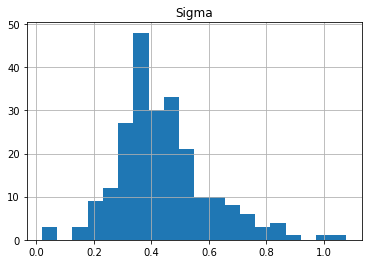

In [62]:
# additional cut based on KS_p value on random systems
random_sig_scores = pd.read_csv("../../csvs/signficance_scores_new_scipy.csv")
print(random_sig_scores.shape)
random_sig_scores_keep = random_sig_scores[(random_sig_scores["KS_P"] > 6.2e-18)]
print(random_sig_scores_keep.shape)
print(random_sig_scores["KS_P"].min())
print(random_sig_scores_keep.shape)
trimmed_random_info_2 = trimmed_random_info[trimmed_random_info["ID"].isin((random_sig_scores_keep["ID"]).values)]
trimmed_random_info_2.hist("Sigma", bins = 20)
plt.show()

(array([ 4.,  0.,  1.,  9., 28., 34., 62., 74., 55., 44., 31., 14., 13.,
         7.,  9.,  4.,  4.,  1.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([0.        , 0.05172414, 0.10344828, 0.15517241, 0.20689655,
        0.25862069, 0.31034483, 0.36206897, 0.4137931 , 0.46551724,
        0.51724138, 0.56896552, 0.62068966, 0.67241379, 0.72413793,
        0.77586207, 0.82758621, 0.87931034, 0.93103448, 0.98275862,
        1.03448276, 1.0862069 , 1.13793103, 1.18965517, 1.24137931,
        1.29310345, 1.34482759, 1.39655172, 1.44827586, 1.5       ]),
 <a list of 29 Patch objects>)

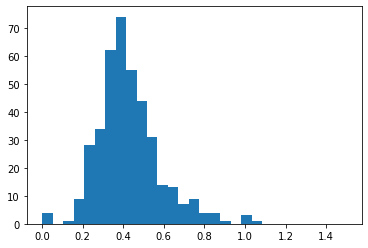

In [63]:
# combined sigma data
combined_sigma = np.concatenate([trimmed_random_info_2["Sigma"], trimmed_res_info_2["Sigma"]])
bins = np.linspace(0, 1.5, 30)
plt.hist(combined_sigma, bins = bins)

In [64]:
# look at the delta times
print(trimmed_res.head())
print(trimmed_random.head())

      ID             t      t_shadow
3    3.0  5.946887e+06  3.941298e+06
4    4.0  3.711381e+05  6.345772e+05
5    5.0  5.828498e+05  1.777121e+06
8    8.0  6.250862e+05  2.305529e+06
13  13.0  1.860666e+04  3.921713e+04
      runstring             t       t_shadow
1   0000001.bin  1.348749e+05  213307.156880
21  0000021.bin  3.590242e+05  646731.388681
22  0000022.bin  2.025537e+06  311291.666001
25  0000025.bin  3.708340e+05  671974.880182
28  0000028.bin  3.374641e+04   41949.192113


(array([  0.,   1.,   1.,   0.,   1.,   2.,   2.,   5.,   4.,   7.,  11.,
         16.,  18.,  14.,  38.,  54.,  68., 118., 144., 205., 269., 300.,
        370., 502., 784., 453., 400., 315., 233., 193., 137.,  92.,  64.,
         62.,  35.,  34.,  23.,  10.,   8.,   8.,   1.,   2.,   3.,   1.,
          0.,   1.,   0.,   0.,   0.]),
 array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
        -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
        -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
        -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0.67346939,
        -0.55102041, -0.42857143, -0.30612245, -0.18367347, -0.06122449,
         0.06122449,  0.18367347,  0.30612245,  0.42857143,  0.55102041,
         0.67346939,  0.79591837,  0.91836735,  1.04081633,  1.16326531,
         1.28571429,  1.40816327,  1.53061224,  1.65306122,  1.7755102 ,
         1.89795918,  2.02040816,  2.14285714,  2.26530612,  2.3877551 ,
       

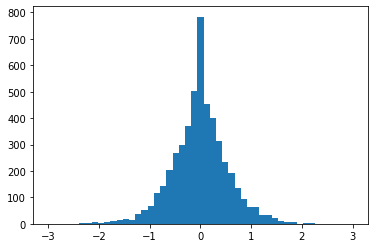

In [65]:
res_delta_diffs = np.log10(trimmed_res["t"] ) - np.log10(trimmed_res["t_shadow"])
random_delta_diffs = np.log10(trimmed_random["t"]) - np.log10(trimmed_random["t_shadow"])
combined_diffs = np.concatenate([random_delta_diffs, res_delta_diffs])
bins = np.linspace(-3, 3, 50)
plt.hist(combined_diffs, bins = bins)

/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


Ks_2sampResult(statistic=0.17553191489361702, pvalue=0.05828609016459707)

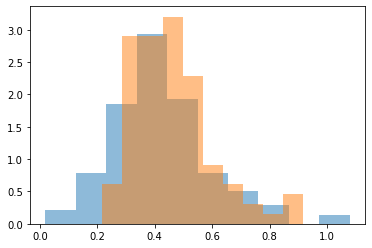

In [66]:
# look at systems with mean instability time between 4 and 5.5, and then 5.5 to 7 separately
# what are their individual sigma distributions
# only for random systems
trimmed_random_info_lower_mean= trimmed_random_info_2[(trimmed_random_info_2["Mean"] < 5.5) &
                                                   (trimmed_random_info_2["Mean"] > 4.0) ]
trimmed_random_info_higher_mean= trimmed_random_info_2[(trimmed_random_info_2["Mean"] < 7) &
                                                   (trimmed_random_info_2["Mean"] > 5.5) ]

plt.hist(trimmed_random_info_lower_mean["Sigma"], alpha = 0.5, normed = 1)
plt.hist(trimmed_random_info_higher_mean["Sigma"], alpha = 0.5, normed = 1)
ks_2samp(trimmed_random_info_higher_mean["Sigma"], trimmed_random_info_lower_mean["Sigma"])

/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Ks_2sampResult(statistic=0.1717171717171717, pvalue=0.16341056240507557)

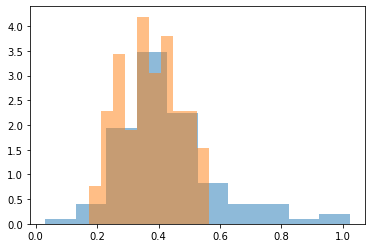

In [67]:
trimmed_res_info_lower_mean = trimmed_res_info_2[(trimmed_res_info_2["Mean"] < 5.5) &
                                                (trimmed_res_info_2["Mean"] > 4) ]
trimmed_res_info_higher_mean = trimmed_res_info_2[(trimmed_res_info_2["Mean"] < 7) &
                                                (trimmed_res_info_2["Mean"] > 5.5) ]

plt.hist(trimmed_res_info_lower_mean["Sigma"], alpha = 0.5, normed = 1)
plt.hist(trimmed_res_info_higher_mean["Sigma"], alpha = 0.5, normed = 1)
ks_2samp(trimmed_res_info_higher_mean["Sigma"], trimmed_res_info_lower_mean["Sigma"])

Ks_2sampResult(statistic=0.07133446263881046, pvalue=0.6859666158861732)


/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/naireen/Documents/pythonVirtualEnvs/ROB501/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


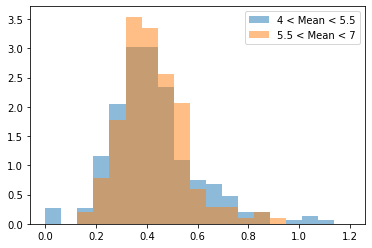

In [68]:
# combine the lower and higher sets
lower_sigmas = np.concatenate([trimmed_random_info_lower_mean["Sigma"], trimmed_res_info_lower_mean["Sigma"]])
higher_sigmas = np.concatenate([trimmed_random_info_higher_mean["Sigma"], trimmed_res_info_higher_mean["Sigma"]])

bins = np.linspace(0, 1.2, 20)
plt.hist(lower_sigmas, alpha = 0.5, normed = 1, bins = bins , label = "4 < Mean < 5.5")
plt.hist(higher_sigmas, alpha = 0.5, normed = 1, bins = bins, label = "5.5 < Mean < 7")
print(ks_2samp(lower_sigmas, higher_sigmas))
plt.legend()

In [69]:
ks_2samp(trimmed_random_info_2["Sigma"], trimmed_res_info_2["Sigma"])

Ks_2sampResult(statistic=0.13007246376811593, pvalue=0.06687512390148376)

In [70]:
ks_2samp(trimmed_random_info_lower_mean["Sigma"], trimmed_res_info_lower_mean["Sigma"])

Ks_2sampResult(statistic=0.09343434343434344, pvalue=0.6763947929442422)

In [72]:
ks_2samp(trimmed_random_info_higher_mean["Sigma"], trimmed_res_info_higher_mean["Sigma"])

Ks_2sampResult(statistic=0.2846935535090505, pvalue=0.0025720544146076163)